In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models

2025-06-25 11:34:13.890065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750831453.920719   20736 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750831453.927637   20736 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750831453.950748   20736 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750831453.950800   20736 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750831453.950801   20736 computation_placer.cc:177] computation placer alr

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

In [4]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

def tf_random_occlusion(image, label, occ_size=(7,7)):
    # get dims
    h, w, _ = image.shape
    h_occ, w_occ = occ_size

    # random top‐left
    x = tf.random.uniform([], 0, h - h_occ + 1, dtype=tf.int32)
    y = tf.random.uniform([], 0, w - w_occ + 1, dtype=tf.int32)

    # create mask
    mask = tf.ones_like(image)
    # pad a small patch of zeros
    zeros = tf.zeros([h_occ, w_occ, 1], dtype=image.dtype)
    mask_patch = tf.pad(zeros,
                        [[x, h - x - h_occ],
                         [y, w - y - w_occ],
                         [0,0]],
                        constant_values=1)

    # apply mask
    occluded = image * mask * mask_patch
    return occluded, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train))
train_ds = train_ds.map(lambda img, lbl: tf_random_occlusion(img, lbl, occ_size=(8,8)),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test))
val_ds = val_ds.map(lambda img, lbl: tf_random_occlusion(img, lbl, occ_size=(8,8)))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1750774088.876342   18465 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


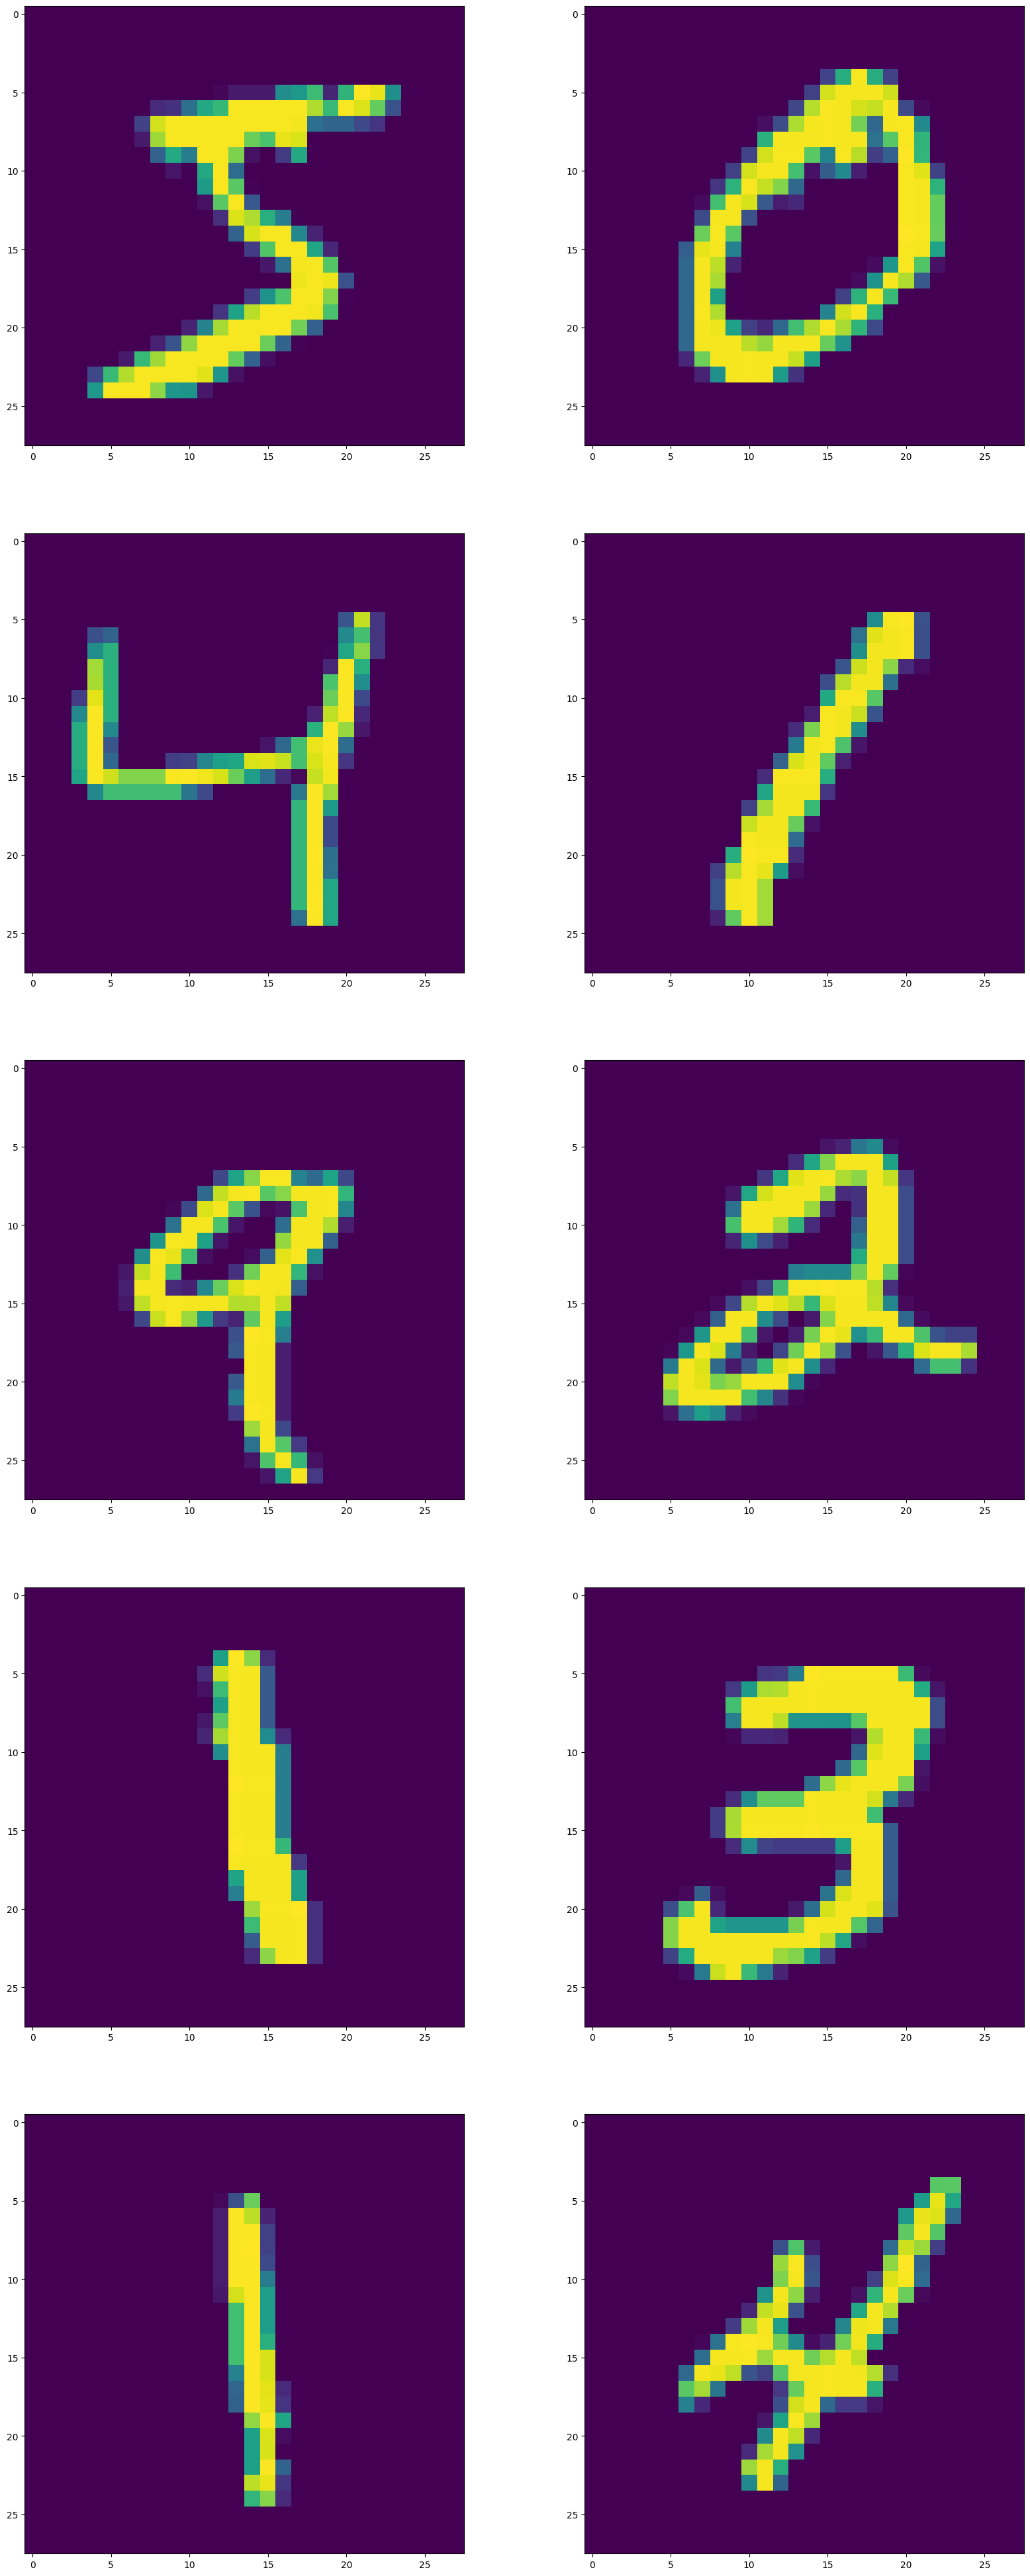

In [5]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 50))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(X_train[i])

In [6]:
X_train.shape

(60000, 28, 28, 1)

In [7]:
X_test.shape

(10000, 28, 28, 1)

In [8]:
encoder = keras.Sequential([
    layers.InputLayer(input_shape = (28, 28, 1)),
    layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    layers.MaxPool2D(pool_size = 2, padding = 'same'),
    layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    layers.MaxPool2D(pool_size = 2, padding = 'same')
])

decoder = keras.Sequential([
    layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    layers.UpSampling2D(size = 2),
    layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    layers.UpSampling2D(size = 2),
    layers.Conv2D(filters = 1, kernel_size = 3, padding = 'same', activation = 'sigmoid')
])

/root/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
from keras import Model, Input

input_img = Input(shape = (28, 28, 1))

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(inputs = input_img, outputs = decoded)

autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam') #since pixelwise loss (MNIST is 0-1 scaled)

history = autoencoder.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10


I0000 00:00:1750774096.689456   18518 service.cc:152] XLA service 0x7e3384004c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750774096.689535   18518 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-06-24 19:38:16.760807: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750774097.143471   18518 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-24 19:38:18.028932: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[64,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,28,28]{3,2,1,0} %bitcast.2340, f32[32,1,3,3]{3,2,1,0} %bitcast.2347, f32[32]{0} %bitcast.2918), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

 17/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.6162

I0000 00:00:1750774100.767041   18518 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1782

2025-06-24 19:38:33.211462: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[32,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0} %bitcast.2340, f32[32,1,3,3]{3,2,1,0} %bitcast.2347, f32[32]{0} %bitcast.2918), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_2_1/sequential_1/conv2d_1/convolution" source_file="/root/tf-gpu/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-24 19:38:33.248235: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1781

2025-06-24 19:38:40.615991: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[64,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,28,28]{3,2,1,0} %bitcast.327, f32[32,1,3,3]{3,2,1,0} %bitcast.334, f32[32]{0} %bitcast.336), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_2_1/sequential_1/conv2d_1/convolution" source_file="/root/tf-gpu/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-24 19:38:40.644392: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot

938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - loss: 0.1780 - val_loss: 0.0919
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0909 - val_loss: 0.0860
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0853 - val_loss: 0.0842
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0831 - val_loss: 0.0818
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0813 - val_loss: 0.0798
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0803 - val_loss: 0.0791
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0793 - val_loss: 0.0781
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0786 - val_loss: 0.0780
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0780 - val_loss: 0.0775
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0776 - val_loss: 0.0771


2025-06-24 19:40:19.809803: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[32,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0} %bitcast.238, f32[32,1,3,3]{3,2,1,0} %bitcast.245, f32[32]{0} %bitcast.247), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_2_1/sequential_1/conv2d_1/convolution" source_file="/root/tf-gpu/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-24 19:40:19.841259: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


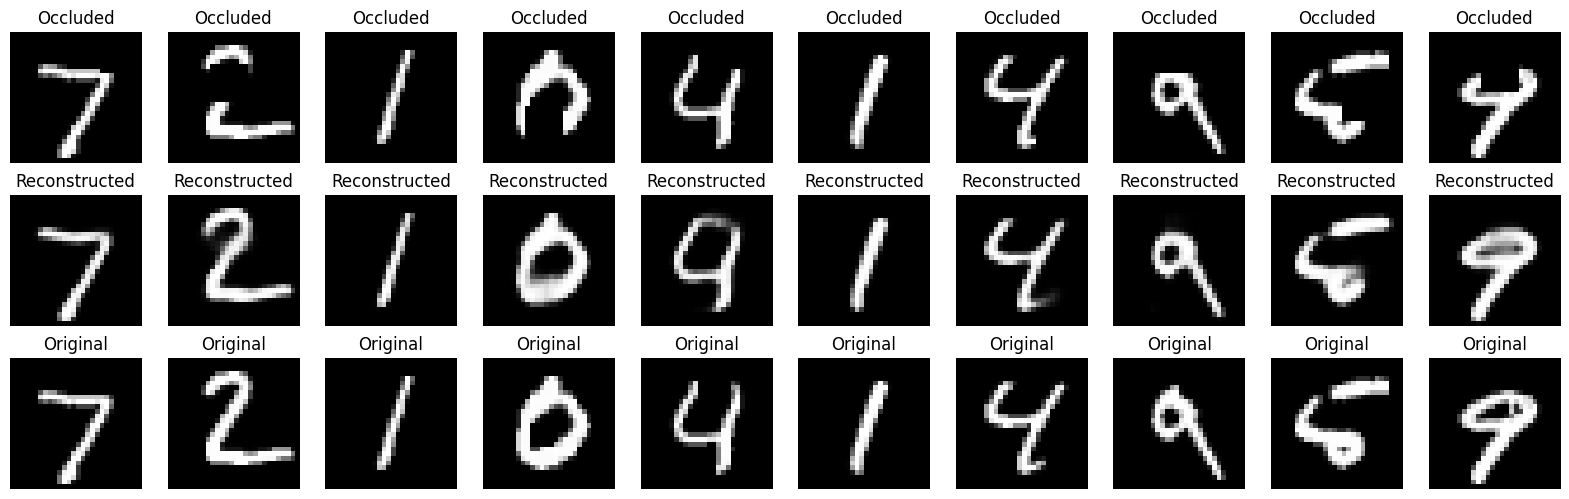

In [10]:
import matplotlib.pyplot as plt

# 1) Grab one batch of (occluded, original) from your val_ds
#    Assume val_ds yields (occluded_img, original_img)
occl_batch, orig_batch = next(iter(val_ds))    # shapes: (batch_size,28,28,1)

# 2) Run your autoencoder on the occluded batch
decoded_batch = autoencoder.predict(occl_batch)  # shape: (batch_size,28,28,1)

# 3) Plot N samples
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Occluded input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(occl_batch[i].numpy().squeeze(), cmap='gray')
    plt.title("Occluded")
    plt.axis('off')

    # Reconstructed output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_batch[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Ground-truth original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(orig_batch[i].numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.show()


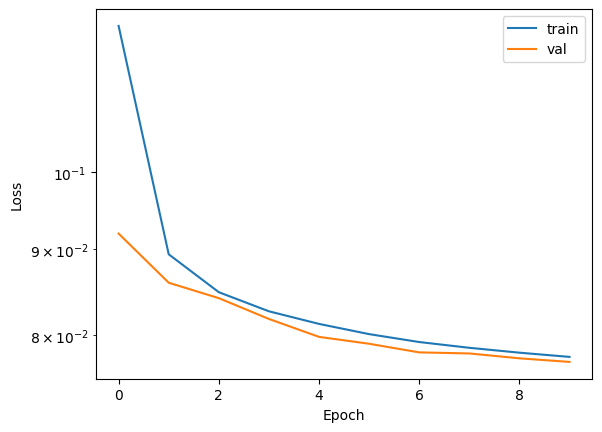

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

In [12]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    x = conv_block(x, filters)
    p = layers.MaxPool2D()(x)
    return x, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(28,28,1)):
    inputs = layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 32)   # 14×14×32
    s2, p2 = encoder_block(p1, 64)       # 7×7×64
    b   = conv_block(p2, 128)            # 7×7×128
    d1  = decoder_block(b, s2, 64)       # 14×14×64
    d2  = decoder_block(d1, s1, 32)      # 28×28×32
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d2)
    return Model(inputs, outputs)


In [14]:
model = build_unet()
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mean_absolute_error"])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 473,537 (1.81 MB)

 Trainable params: 472,257 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [15]:
history1 = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10


2025-06-24 19:45:05.125566: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.34 = (f32[64,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,28,28]{3,2,1,0} %bitcast.11022, f32[32,32,3,3]{3,2,1,0} %bitcast.8812, f32[32]{0} %bitcast.11082), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_6_1/convolution" source_file="/root/tf-gpu/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-24 19:45:05.238196: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potenti

937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0184 - mean_absolute_error: 0.0855

2025-06-24 19:45:42.649438: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.34 = (f32[32,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,28,28]{3,2,1,0} %bitcast.11022, f32[32,32,3,3]{3,2,1,0} %bitcast.8812, f32[32]{0} %bitcast.11082), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_6_1/convolution" source_file="/root/tf-gpu/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-24 19:45:42.795225: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potenti

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0184 - mean_absolute_error: 0.0854

2025-06-24 19:45:56.800460: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.33 = (f32[16,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,28,28]{3,2,1,0} %bitcast.1065, f32[32,1,3,3]{3,2,1,0} %bitcast.1072, f32[32]{0} %bitcast.1074), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_5_1/convolution" source_file="/root/tf-gpu/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-24 19:45:56.875790: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially

938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 49ms/step - loss: 0.0184 - mean_absolute_error: 0.0854 - val_loss: 0.0037 - val_mean_absolute_error: 0.0236
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - loss: 0.0032 - mean_absolute_error: 0.0194 - val_loss: 0.0032 - val_mean_absolute_error: 0.0165
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0027 - mean_absolute_error: 0.0143 - val_loss: 0.0025 - val_mean_absolute_error: 0.0122
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0025 - mean_absolute_error: 0.0124 - val_loss: 0.0027 - val_mean_absolute_error: 0.0119
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - loss: 0.0023 - mean_absolute_error: 0.0111 - val_loss: 0.0023 - val_mean_absolute_error: 0.0105
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 0.0022 - mean_absolute_error: 0.0102 - val_loss: 0.0022 - val_mean_absolute_error: 0.0098
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0021 - mean_absolute_error: 0.0096 

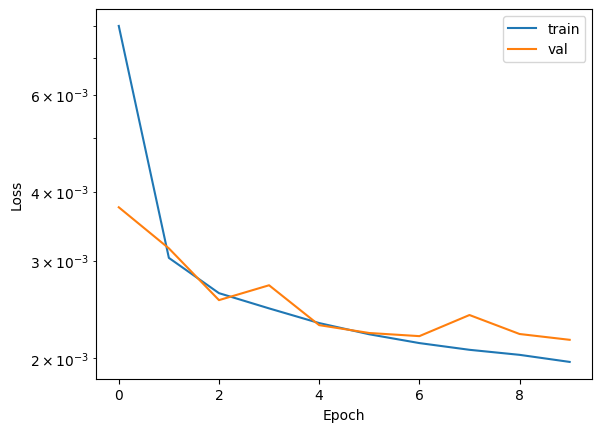

In [16]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='val')
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


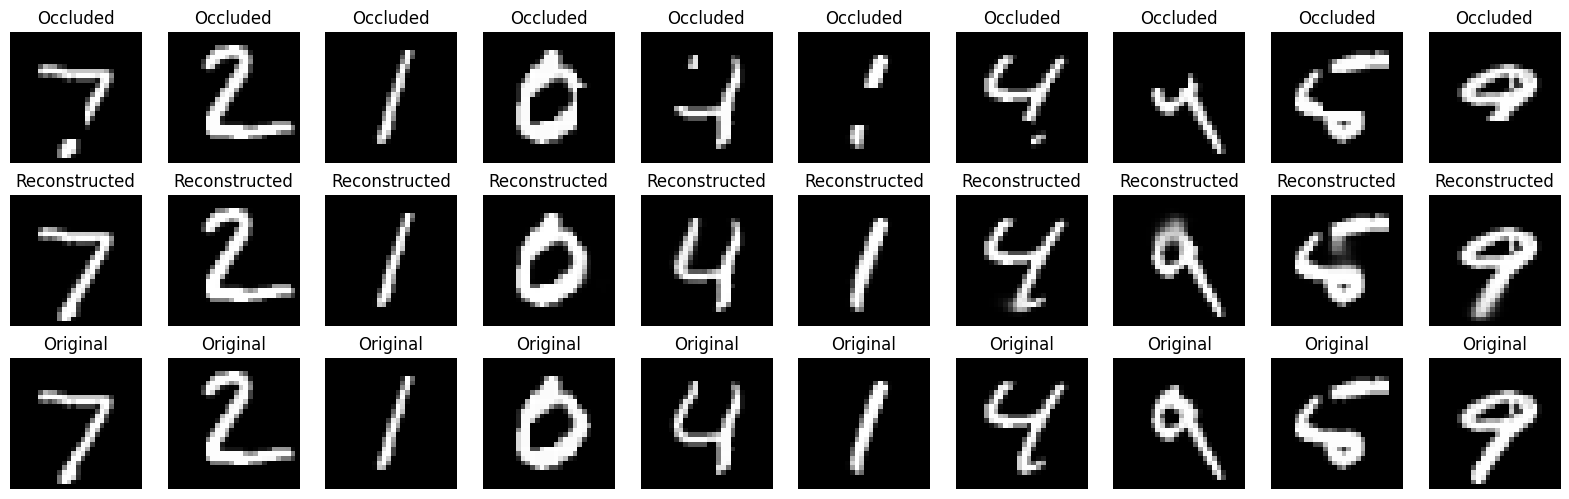

In [17]:
import matplotlib.pyplot as plt

# 1) Grab one batch of (occluded, original) from your val_ds
#    Assume val_ds yields (occluded_img, original_img)
occl_batch, orig_batch = next(iter(val_ds))    # shapes: (batch_size,28,28,1)

# 2) Run your autoencoder on the occluded batch
decoded_batch = model.predict(occl_batch)  # shape: (batch_size,28,28,1)

# 3) Plot N samples
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Occluded input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(occl_batch[i].numpy().squeeze(), cmap='gray')
    plt.title("Occluded")
    plt.axis('off')

    # Reconstructed output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_batch[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Ground-truth original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(orig_batch[i].numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.show()
